In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
import seaborn as sns
import os
import csv
import itertools
import operator

# Author - Alberto Rocha - 200202358
# Homework Assignment #2 for the Network Science Course in the Data Science Masters Degree, FCUP in 2021/2022
# Submitted on 22/05/2022

## 1. Draw a network in which one node has a very high value of PageRank, although the same node has low closeness and betweenness centrality (don’t forget to point out the node).

Such a node would be a node that other nodes with high page rank connect to, despite being in a peripherical position where it fails to be part of the shortest path between other nodes and has on average long shortest paths to other nodes. An example of such a scenario would be node **A** on the network below: Despite only possessing a mutual connection to node **C**, resulting in zero betwenness centrality and small-ish closeness centrality it has the 3rd highest pagerank score in the network since the remaining nodes are very densily connected, reinforcing **C** directly as well as **E**, which further reinforces **C**. This effect cascades into inflating the score for node **A**. Below we also present the calculations obtained with **networkx**.

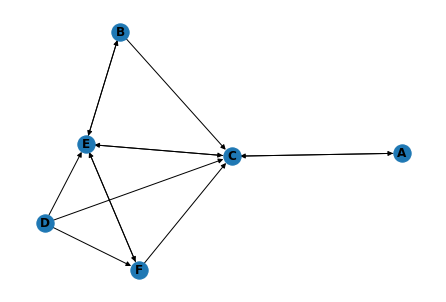

Betwenness centrality {'A': 0.0, 'B': 0.0, 'C': 0.35000000000000003, 'D': 0.0, 'E': 0.35000000000000003, 'F': 0.0}
Closeness centrality {'A': 0.5555555555555556, 'B': 0.5, 'C': 1.0, 'D': 0.0, 'E': 0.8333333333333334, 'F': 0.5555555555555556}
pagerank {'A': 0.16838179991566507, 'B': 0.09954052105389594, 'C': 0.3373683180975084, 'D': 0.025, 'E': 0.2630855065457013, 'F': 0.10662385438722927}


In [2]:
# We create the network

F = nx.DiGraph()

F.add_nodes_from(['A','B','C','D','E','F'])
F_edgelist = [('E','B'),
            ('B','E'),
            ('B','C'),
            ('D','C'),
            ('F','C'),
            ('E','F'),
            ('F','E'),
            ('E','C'),
            ('C','E'),
            ('C','A'),
            ('D','F'),
            ('D','E'),
            ('A','C')]

F.add_edges_from(F_edgelist)

nx.draw_kamada_kawai(F, with_labels=True, font_weight='bold')
plt.show()
print(f'Betwenness centrality {nx.betweenness_centrality(F)}')
print(f'Closeness centrality {nx.closeness_centrality(F)}')
print(f'pagerank {nx.pagerank(F)}')

## 2. The damping factor in PageRank (parameter β, in slides) controls how of often we follow one of the links of the current node vs going to an arbitrary node on the network.

### (a) What does β = 0 mean? What would happen to the PageRank values in that case? Why?

A $\beta$ of 0 would result in the page rank for every page to be locked into 1 due to the score being calculated as 1-$\beta$ + $\beta$ * ... Effectively, the 'surfer' would keep jumping to a random page after each click with 1.0 probability, meaning the page rank of each page would be locked into the value of 1 with no possibility of change regardless of iterations, making the purpose of the ranking exercise unreachable.

### (b) What does β = 1 mean? Can you explain a possible problem with using that value?

A $\beta$ value of 1 would result in the 'surfer' being unable to perform random jumps in the network, meaning that everytime it reaches a dead-end node no further jumps would be available, making it impossible for the page rank values to converge to a stable value on further iterations.

## 3. Implement a program (in any programming language) for manually computing the (normalized) PageRank values of a small network using power iterations (the ”flow” mode). Attach the program to your homework submission with a very short description on how it works.

The program below calculates the page rank for each node with the support from some core **networkx** functionality; A solution that relies solely on core python would be ideal, and node enumeration and adjacency matrix creation were included in the earlier versions, but time constraints prevented us from optimizing the output format of each intermediate step; The program presented below works by:

* Processing the input network, obtaining a list of nodes and a dict of node degrees;
* Building the adjacency matrix with the built-in function of **networkx**;
* Initializing ranks by assigning first, the degrees of each node (explained below in the aux function) and then the initial rank for every node: $\frac{1}{n}$;
* Initializing a history list, used to store each iteration of the page rank calculations. The first element of this list will be the initial ranks calculated in the previous step;
* Setting a counter to 1. 1 is added to it after each iteration. This counter will be used to index the history list in order to retrieve the ranks from the previous iteration;
* Calculating the updated page rank for each new iteration, while the threshold holds. This threshold is evaluated by an auxiliary function detailed below;
* The calculation is obtained as per described in the lectures. For each node: $\frac{1-\beta}{n} * \beta*\sum \frac{rank_{t_1}}{degree}$
* Due to some issues with infinite loops, possibly due to spider traps during testing, a hard-cap of 1000 iterations is put in place;
* The updated ranks are added to the history list;
* While the sum of the module of the differences between the new ranks and the previous iteration's ranks is above the threshold, a new iteration is triggered.

The last criterion is tested by an auxiliary function that tests the difference between the current iteration and the previous. In order for the check to succeed on the first iteration, a dummy item in the first position of the history is required. The use of the degree list meets format requirements and ensures the first *while* check is passed, allowing the first iteration to occur.

In [11]:
def epsilon(t1, t0, threshold):
    res1 = np.sum([np.abs(i - j) for i,j in zip(t1, t0)])
    return res1 > threshold

def paijerranque(net, beta, threshold = 0.0001):
    n = len(net)

    # nodes as a list:
    nodes = list(net.nodes)

    # Degrees as a dict:
    degrees = dict(net.out_degree)

    # Initialize adjacency matrix:
    A = nx.to_pandas_adjacency(G)

    # initialize rank list:
    rank = []
    for i in nodes:
        rank.append(1/n)

    # initialize iterations history tracker:
    history = []
    history.append(degrees.values())
    history.append(rank)
    counter = 1

    # update ranks for each iteration:

    while epsilon(history[counter], history[counter - 1], threshold):
        if counter >= 1000:
            print('404 convergence not found!')
            break
        r_t = []
        for t in nodes:
            a_t = A[t]
            res = (1 - beta)/n + beta * np.sum(a_t * history[counter] / list(degrees.values()))
            r_t.append(res)
        history.append(r_t)
        counter += 1
    # cleanup and wrapup
    del history[0]
    print(f'result obtained after {len(history)} iterations')
    return history, counter

## 4. Use your program to compute the PageRank values of the following network (with β = 0.85). Show the values of all nodes for each iteration until the computation converges.

We start by importing the network, using the methodology previously used in Homework 1. A Kamada-Kawai layout was chosen (by trial and error) for clarity.

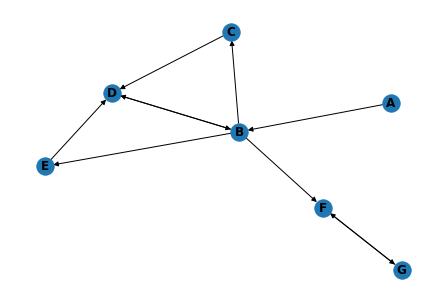

OutEdgeView([('A', 'B'), ('B', 'C'), ('B', 'D'), ('B', 'E'), ('B', 'F'), ('C', 'D'), ('D', 'B'), ('E', 'D'), ('F', 'G'), ('G', 'F')])

In [4]:
G = nx.DiGraph()

# We create the network
G.add_nodes_from(['A','B','C','D','E','F','G'])
edgelist = [('A','B'),
            ('B','C'),
            ('B','D'),
            ('B','E'),
            ('B','F'),
            ('C','D'),
            ('D','B'),
            ('E','D'),
            ('F','G'),
            ('G','F')]

G.add_edges_from(edgelist)

nx.draw_kamada_kawai(G, with_labels=True, font_weight='bold')
plt.show()
G.nodes
G.edges

The pagerank for each node, after convergence, is, according to **networkx**:

In [5]:
nx.pagerank(G)

{'A': 0.021428571428571432,
 'B': 0.1733735640818441,
 'C': 0.058270455785194145,
 'D': 0.15733023504801089,
 'E': 0.058270455785194145,
 'F': 0.275619160364745,
 'G': 0.25570755750644003}

Our custom function achieves similar values after convergence:

In [21]:
G_pr = paijerranque(G, 0.85)
G_pr[0]

result obtained after 41 iterations


[[0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 [0.021428571428571432,
  0.26428571428571423,
  0.05178571428571428,
  0.2946428571428571,
  0.05178571428571428,
  0.1732142857142857,
  0.14285714285714285],
 [0.021428571428571432,
  0.2900892857142856,
  0.07758928571428571,
  0.165625,
  0.07758928571428571,
  0.19901785714285714,
  0.16866071428571427],
 [0.021428571428571432,
  0.18042410714285714,
  0.08307254464285713,
  0.2149743303571428,
  0.08307254464285713,
  0.22643415178571424,
  0.19059375],
 [0.021428571428571432,
  0.22237103794642854,
  0.05976869419642858,
  0.20099202008928568,
  0.05976869419642858,
  0.22177338169642857,
  0.21389760044642853],
 [0.021428571428571432,
  0.21048607421874999,
  0.0686824169921875,
  0.1702891971261161,
  0.0686824169921875,
  0.25049537737165173,
  0.2099359458705357],
 [0.021428571428571432,
  0.18438867470005582,
  0.

## 5. Use the program to do computations varying the β parameter from 0.0 to 1.0 in steps of 0.05 and:

### (a) Show in a plot the number of iterations needed until convergence is reached as you change β. Can you explain what is happening?


In [17]:
x_temp = 0
x_beta = []

while x_temp <= 1.04:
    x_beta.append(x_temp)
    x_temp += 0.05

y_beta = [paijerranque(G, i)[1] for i in x_beta]

result obtained after 2 iterations
result obtained after 4 iterations
result obtained after 5 iterations
result obtained after 6 iterations
result obtained after 6 iterations
result obtained after 7 iterations
result obtained after 8 iterations
result obtained after 9 iterations
result obtained after 9 iterations
result obtained after 10 iterations
result obtained after 11 iterations
result obtained after 13 iterations
result obtained after 15 iterations
result obtained after 17 iterations
result obtained after 20 iterations
result obtained after 24 iterations
result obtained after 30 iterations
result obtained after 41 iterations
result obtained after 62 iterations
result obtained after 125 iterations
404 convergence not found!
result obtained after 1000 iterations


With $\beta = 1$ we hit the 1000 iterations cap. Removing the cap results in the process being stuck in a permanent loop. The answer to the next question should shed some light whether we are in the presence of a spider trap when we set such a unreasonable value for $\beta$

(0.0, 200.0)

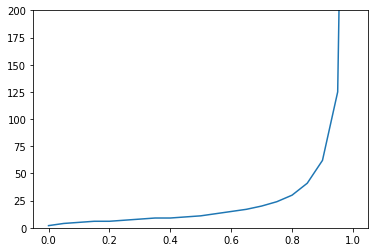

In [20]:
plt.plot(x_beta, y_beta)
plt.ylim(0,200)

### (b) Show in a plot the different PageRank values of all nodes as your change β. Can you divide the nodes into different curve behaviors? Can you explain what is happening?

As expected from the previous results, with very high values for $\beta$ nodes F and G become spider traps, absorbing all importance in the ranks, with their combined ranks converging assymptotically to 1. Nodes A end E decrease linearly in rank with rising damping values, where as nodes B and D rise linearly in rank up until $\beta = 0.75$, after which they experience an abrupt cutoff, drive by the rise of F and G.

In [ ]:
y_A = [paijerranque(G, x_beta[i])[0][i][0] for i,_ in enumerate(x_beta)]
y_B = [paijerranque(G, x_beta[i])[0][i][1] for i,_ in enumerate(x_beta)]
y_C = [paijerranque(G, x_beta[i])[0][i][2] for i,_ in enumerate(x_beta)]
y_D = [paijerranque(G, x_beta[i])[0][i][3] for i,_ in enumerate(x_beta)]
y_E = [paijerranque(G, x_beta[i])[0][i][4] for i,_ in enumerate(x_beta)]
y_F = [paijerranque(G, x_beta[i])[0][i][5] for i,_ in enumerate(x_beta)]
y_G = [paijerranque(G, x_beta[i])[0][i][6] for i,_ in enumerate(x_beta)]

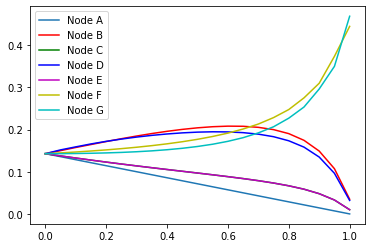

In [43]:
plt.plot(x_beta, y_A, label = 'Node A')
plt.plot(x_beta, y_B, 'r', label = 'Node B')
plt.plot(x_beta, y_C, 'g', label = 'Node C')
plt.plot(x_beta, y_D, 'b', label = 'Node D')
plt.plot(x_beta, y_E, 'm', label = 'Node E')
plt.plot(x_beta, y_F, 'y', label = 'Node F')
plt.plot(x_beta, y_G, 'c', label = 'Node G')

plt.legend(loc='best')

## 6. For this exercise you will be asked to analyze a set of networks depicting the ”social networks” (character co-occurrences in a scene) of 5 well known movies (you can download gml files here: movies.zip): Start by opening the files on a text editor to see how they internally look like.

### (a) Using Gephi, networkx (both can read networks in the gml format) or any other platform/library, you should run Louvain Algorithm to find the best possible communities and create a table showing: name of the movie, number of nodes and edges, number of communities found and modularity for those communities. Give a brief comment on which networks seem to present community structure, and why.

As in previous exercises, **networkx** was used for this task. If we use the reference interval of [0.3, 0.7], as presented in the lectures, then all five networks appear to present community structure, with the highest modularity being found in 'The Godfather II'.

In [44]:
files = os.listdir('movies/')
networks = [nx.read_gml('movies/'+file) for file in files]
louvain = [nx.algorithms.community.louvain_communities(nw, seed = 123) for nw in networks]
mod = []
for i, _ in enumerate(networks):
    res = nx.algorithms.community.modularity(networks[i], louvain[i])
    mod.append(res)

data = list(zip(files,
         [len(rede.nodes) for rede in networks],
         [len(rede.edges) for rede in networks],
         [len(item) for item in louvain],
         np.round(mod,3)))

df = pd.DataFrame(data,
               columns =['Network', 'Nodes','Edges','Communities', 'Modularity'])
df

,Network,Nodes,Edges,Communities,Modularity
0,bladerunner.gml,25,44,4,0.439
1,godfather_ii.gml,78,219,5,0.484
2,lordrings_returnking.gml,35,98,3,0.388
3,pulp_fiction.gml,38,102,5,0.379
4,starwars_v.gml,37,82,5,0.393


##  (b) Choose any two of the movies and produce visualizations for the networks, labeling the nodes with their character names, using colors to represent communities and the size of the nodes to represent PageRank values. Try to make the picture as aesthetically pleasing as possible, reinforcing the community structure (and explain how you created the layout). Give a brief informal description on the meaning of the communities in the context of the movie (are they what you were expecting? are they meaningful? choose movies that you are familiar with).

I've only seen 2 movies from this list, and this exercise showed me I am not as familiar with them as I thought I was. Below it is included, for reference, an attempt at a visualization in **networkx**. This approach proved more trouble than it is worth, so **Gephi** visualizations will be presented instead. The chosen films are 'Pulp Fiction' and 'Star Wars'. Modularity and PageRank were calculated in the statistics panel and node size/color were set to specifications. The layout used in both images was 'Yifan Hu' since it provides the best spatial separation of the communities. It should be noted that both networks were grouped into 4 communities in **Gephi**, with the default resolution. Increasing this value could have forced for a 5 community to emerge, matching **networkx** separation, but we decided to present the default scenario.

I don't have a good enough recollection of 'Pulp Fiction' to appreciate the accuracy of these communities. Jules was assigned to the same community as Brett, Marvin and Roger, which is consistent with my recollection of the Psalm and the 'you shot Marv' scenes. Butch, Zed and the Gimp were assigned the same community, which makes sense due to the 'back of the shop' scene, though Marsellus, who was central to that scene, was given the same community as Jules, meaning the scenes concerning the briefcase were given more importance. The blue community appears to involve people related to some bar, hotel, nightclub? Maybe the dance scene? They do share a motif, but my knowledge of the movie is not sufficient.

![pulpfiction](pulp_fiction_viz.png)

 As for 'Star Wars: Episode V' (which I have actually some memories of), some clear patterns are evident. The pink community includes most of the antagonists. Luke is separated from the other protagonists in the blue community, sharing it with Jedi-themed characters such as 'strange voice' (Force?), Yoda and Ben Kenobi. I have no idea who the other characters are. The protagonists associated with the Rebel Faction (Leia, Han, Lando) are included in the green community. The two remainign communities involve minor characters, probably associated solely by the scenes they shared. Since this network fails to include the best character (R2-D2), it is null and void and wrong by default.

![map](star_wars_viz.png)


<Figure size 8x6 with 0 Axes>

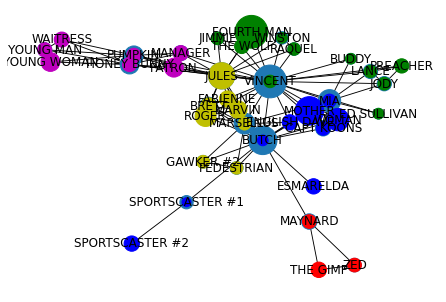

<Figure size 8x6 with 0 Axes>

In [45]:
#https://stackoverflow.com/questions/50828284/networkx-specifying-colors-to-communities-nodes-in-a-graph

# Pulp fiction:
## communities:

pulp_com = louvain[3]
G_pulp = networks[3]
pr_pulp = nx.pagerank(G_pulp)
scaling = 10000
#node_pr = [v * scaling for v in pr_pulp.values()]
node_pr = [v * scaling for k, v in pr_pulp.items()]

pos = nx.spring_layout(G_pulp) #calculate position for each node
# pos is needed because we are going to draw a few nodes at a time,
# pos fixes their positions.

com_size_0 = [value * scaling for (key, value) in pr_pulp.items() if key in pulp_com[0]]
com_size_1 = [value * scaling for (key, value) in pr_pulp.items() if key in pulp_com[1]]
com_size_2 = [value * scaling for (key, value) in pr_pulp.items() if key in pulp_com[2]]
com_size_3 = [value * scaling for (key, value) in pr_pulp.items() if key in pulp_com[3]]
com_size_4 = [value * scaling for (key, value) in pr_pulp.items() if key in pulp_com[4]]


# Draw the graph, but don't color the nodes
nx.draw(G_pulp, pos, edge_color='k',  with_labels=True,
         font_weight='light', width= 0.9, node_size = node_pr)


#For each community list, draw the nodes, giving it a specific color.
nx.draw_networkx_nodes(G_pulp, pos, nodelist=pulp_com[0], node_color='b', node_size= com_size_0)
nx.draw_networkx_nodes(G_pulp, pos, nodelist=pulp_com[1], node_color='r', node_size= com_size_1)
nx.draw_networkx_nodes(G_pulp, pos, nodelist=pulp_com[2], node_color='g', node_size= com_size_2)
nx.draw_networkx_nodes(G_pulp, pos, nodelist=pulp_com[3], node_color='y', node_size= com_size_3)
nx.draw_networkx_nodes(G_pulp, pos, nodelist=pulp_com[4], node_color='m', node_size= com_size_4)
#nx.draw_networkx_nodes(G_pulp, pos, nodelist=pulp_com[5], node_color='c')

plt.figure(figsize=(8, 6), dpi=1)



## (c) Implement a program (in any programming language) for manually computing the (normalized) modularity of a network when given a partition. Test it on one movie of your choice and the partitions you produced on the previous questions (and report if the value seems ok). Attach the program to your homework submission with a very short description on how it works.

The program we came up with that measures modularity works by:

* creating an auxiliary function *sigma()* that calculates whether any 2 given nodes belong to the same partition. Eventually I realized the symbol in the formula is actually a delta, but now I'm attached to the original name;
* On the main function, initializing the measures that will be used in the modularity calculation: Number of edges, list of nodes, adjacency matrix as well as a null variable where modularity will be stored.
* iterates over the node list twice, in parallel. An itertools solution for iterating over combinations was attemtped, but resulted in wrong values for the calculation. Due to time constraints, caveman level of python will have to do.
* The modularity calculation for any pair of nodes *i* and *j* is split in 3 parts for clarity:
    * Retrieve the corresponding entry in the adjacency matrix;
    * multiply the respective degrees and divide by $2*m$;
    * run the auxiliary function to determine whether the 2 nodes share a partition;
* The contribution of that pair is then added to the modularity variable. The total value for modularity is returned at the end.

In [104]:
def sigma(node1, node2, partitions):
    res = []
    [res.append(1) for part in partitions if node1 in part and node2 in part]
    return 1 if sum(res) > 0 else 0

def modularidade(net, partitions):
    A = nx.adjacency_matrix(net)
    nodes = list(net.nodes)
    degree = [j for i, j in nx.degree(net)]
    m = len(net.edges)
    mod = 0

    for i, _ in enumerate(nodes):
        for j, _ in enumerate(nodes):
            pt1 = A[i,j]
            pt2 = (degree[i] * degree[j]) / (2*m)
            pt3 = sigma(nodes[i], nodes[j], partitions)

            mod += ((pt1 - pt2) * pt3) /(2*m)
    return mod

We can test our function with the first movie network, provided, 'Blade Runner':

In [105]:
modularidade(networks[0], louvain[0])

C:\Users\user\AppData\Local\Temp\ipykernel_31612\457566855.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(net)


0.4393078512396689

And we can confirm it works by comparing with the **networkx** implementation of this calculation:

In [106]:
nx.algorithms.community.modularity(networks[0], louvain[0])

0.4393078512396694

### (d) Implement (in any programming language) a simple greedy agglomerative algorithm: start with each node being a separated community and then do sucessive iterations in which you try all possible changes for one node (that is, for each node i ∈ V , try changing its community to all possible communities j ∈ C), and apply the change that produces the best gain in modularity (if there is ties, choose any possible). Attach the program to your homework submission with a very short description on how it works. Make a plot showing the modularity increase as you are making more iterations until you reach you a ”local maximum”, and report the communities you found (as a visualization), comparing them to the communities found previously.

The solution is presented below. This program performs the following tasks:

* Create an auxiliary function that converts the dict of communities that the main function will create into a list of sets; this is a requirement of both **networkx** and the custom function created for the previous question. This proved to be the biggest hurdle for this task.
* Start the main function by initializing a list of nodes and using to create a dict of communities, where each node is assigned its own community.
* Iterate over the node list twice, one for each node and for each node, for all possible communities.
    * In each iteration, a copy of the community dict is created. On that copy, a new community is assigned to the node.
    * If the modularity of the new temp dict is higher than the pre-existing community dict, then the change in community is accepted and stored in the main community list.
* In the end, the final community dict is returned. The aux function can be used to convert the dict into a list of sets.

In [227]:
# aux based on https://stackoverflow.com/questions/31032658/python-splitting-dictionary-into-dictionaries-with-the-same-values

def conversor(new_partition):
    #invertido = {values: keys for keys, values in new_partition.items()}
    by_value = operator.itemgetter(1)
    teste_set = [set(g) for k, g in itertools.groupby(sorted(new_partition.items(), key = by_value), by_value)]
    ordenado = [sorted(i) for i in teste_set]
    res = [set([j[0] for j in i]) for i in ordenado]
    return res

def ganancioso(net):
    # list of nodes:
    nodes = list(net.nodes)
    # dict of communities
    community = {node : node for node in nodes}

    for i in nodes:
        for j in nodes:
            temp = community.copy()
            temp[i] = j
            if modularidade(net, conversor(temp)) > modularidade(net, conversor(community)):
                community[i] = j
    return community

We can test our program with the 'Bladerunner' network. The nodes have been split in 9 communities:

In [230]:
blade_runner = ganancioso(networks[0])
blade_runner

C:\Users\user\AppData\Local\Temp\ipykernel_31612\457566855.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(net)


{'DECKARD': 'ESPER',
 'TYRELL': 'IAN',
 'SEBASTIAN': 'CHEW',
 'BATTY': 'ANNOUNCER',
 'LEON': 'ANNOUNCER',
 'RACHAEL': 'BRYANT',
 'PRIS': 'MOUSE',
 'ANNOUNCER': 'ANNOUNCER',
 'BARTENDER': 'RUSSIAN',
 'BRYANT': 'BRYANT',
 'CHEW': 'CHEW',
 'COP': 'SERGEANT',
 'ESPER': 'ESPER',
 'GAFF': 'ESPER',
 'HOLDEN': 'ANNOUNCER',
 'IAN': 'IAN',
 'MARY': 'PIG',
 'MOUSE': 'MOUSE',
 'PIG': 'PIG',
 'RACHEL': 'IAN',
 'RUSSIAN': 'RUSSIAN',
 'SALOME': 'ESPER',
 'SERGEANT': 'SERGEANT',
 'TAFFEY': 'ESPER',
 'WHEELER': 'ESPER'}

We can proceed to plot this result:

<Figure size 8x6 with 0 Axes>

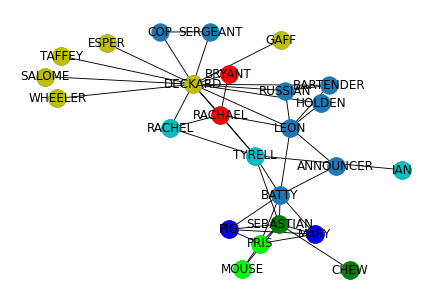

<Figure size 8x6 with 0 Axes>

In [236]:
br_com = conversor(blade_runner)
G_br = networks[0]

pos = nx.spring_layout(G_br) #calculate position for each node

# Draw the graph, but don't color the nodes
nx.draw(networks[0], pos, edge_color='k',  with_labels=True,
         font_weight='light', width= 0.9)


#For each community list, draw the nodes, giving it a specific color.
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[0])
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[1], node_color='r')
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[2], node_color='g')
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[3], node_color='y')
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[4], node_color='c')
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[5], node_color='lime')
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[6], node_color='gold')
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[6], node_color='m')
nx.draw_networkx_nodes(networks[0], pos, nodelist=br_com[6], node_color='b')


plt.figure(figsize=(8, 6), dpi=1)

### (e) Using your previous program as a basis, explain how could you obtain a larger quantity of communities? And how could you obtain less communities?
The most obvious entry point for a tuning parameter (the equivalent of resolution, in the *louvain* function of **networkx** would be the condition that stablishes wether a community change is validated. We could add a weight to the comparison so a stricter or more lax threshold on the modularity gain is in place before the node is assigned a new community.

# 7.

## (a) Consider the following undirected network: (...). Your task here is to determine the number of occurrences of all subgraphs of size 4 in this network. You should put in the report a table like the one shown above (the html version of the output is ”broken”, so you should produce your own images of the subgraphs)

After sucessfully compiling *gtrieScanner* with Cygwin we were able to test the program on the network.txt table. Below we present the results for size 4 subgraphs occurrence:

First, we draw the thumbnails for the subgraphs. These plots were screenshoted and are included in the same folder as this notebook

In [ ]:
m4_1 = nx.Graph()

m4_1.add_nodes_from(['A','B','C','D'])
m4_1.add_edges_from([('A','B'), ('A','C'), ('B','D')])

nx.draw(m4_1)

m4_2 = nx.Graph()

m4_2.add_nodes_from(['A','B','C','D'])
m4_2.add_edges_from([('A','B'), ('A','C'), ('A','D'), ('B','C')])

nx.draw(m4_2)

m4_3 = nx.Graph()

m4_3.add_nodes_from(['A','B','C','D'])
m4_3.add_edges_from([('A','B'), ('A','C'), ('A','D')])

nx.draw(m4_3)

m4_4 = nx.Graph()

m4_4.add_nodes_from(['A','B','C','D'])
m4_4.add_edges_from([('A','B'), ('A','C'), ('B','D'), ('C','D')])

nx.draw(m4_4)

m4_5 = nx.Graph()

m4_5.add_nodes_from(['A','B','C','D'])
m4_5.add_edges_from([('A','B'), ('A','C'), ('A','D'), ('B','C'), ('B','D')])

nx.draw(m4_5)

The output of **gtrieScanner** is, thus:

Method: ESU on original network
Different Types of Subgraphs Found [Original Network]: 5
Subgraph Occurrences Found [Original Network]: 32
Time for computing census on original network: 0.000115s
Average time for census on random network: 0.000000s

Number of random networks: 0
Random seed: 1652745520
Exchanges per edge: 3
Number of tries per exchange: 10

In [70]:
# As seen in:
# https://stackoverflow.com/questions/47113934/how-to-display-table-with-text-and-images-in-jupyter-notebook

img = ['sg_41.png',
       'sg_42.png',
       'sg_43.png',
       'sg_44.png',
       'sg_45.png']

img_path = {'<img src="'+ 'sg_41.png' + '" width="60" >',
            '<img src="'+ 'sg_42.png' + '" width="60" >',
            '<img src="'+ 'sg_43.png' + '" width="60" >',
            '<img src="'+ 'sg_44.png' + '" width="60" >',
            '<img src="'+ 'sg_45.png' + '" width="60" >'}

data2 = list(zip(img,
         [21,5,4,1,1]))

def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'
    #return '![text](' + path + ')'


pd.set_option('display.max_colwidth', None)
format_dict = {'Graph' : path_to_image_html}


table7a = pd.DataFrame(data2,
               columns =['Graph', 'Org_Freq'])
display(HTML(table7a.to_html(escape=False, formatters= format_dict)))
plt.show()

,Graph,Org_Freq
0,,21
1,,5
2,,4
3,,1
4,,1


## (b) Imagine you have a Gn,p undirected Erd˝os–R´enyi random network. What is its expected number of triangles ( )? And what about the expected number of chains ( )? Justify your answer. Note that you can test your theory by generating Erd˝os–R´enyi networks and counting the subgraphs using gtrieScanner, but your answer should be stated as formulas involving n and p.

Graphs used to test my answer will be generated using the built-in function of **networkx**. The answer created in the previous assignment could have also been used, but for this purpose this function is guaranteed to perform better and be more accurate.

We can estimate the number of chains by estimating the probability of a given node *i* being the center node in a chain. For *n* nodes, there are (n-1)(n-1-1)/2 possible pairs from the remaining nodes. In a random network, node *i* can link to each of the nodes with probability *p*. So, the probability of node *i* to form edges with any given pair (A,B) (and therefore becoming the central node in a chain A-*i*-B can be expected to be:

$E[chains] = n * \frac{(n-1)(n-2)}{2}p^2$

As for triangles, we can follow the same line of thought: Any given node *i* will form a link with nodes (A,B) with probability $p^2$, and the probability of nodes (A,B) being linked is also *p*. Therefore, for all possible combinations, the probability of a triangle being formed is $p^3$. The expected ammount of triangles in a network of size *n* should be, therefore

$E[triangles] = n * \frac{(n-1)(n-2)}{2}p^3 * \frac{1}{3}$

The estimate is divided by 3 to account for isomorphisms.

To test this hypothesis, a random network with $n = 1000$ and $p = 0.05$ was generated. All nodes were renamed by adding 1 to their index, since **gtrieScanner** throws an error when nodes with indexes of 0 are present. The expected number of triangles, according to our hypothesis, would be 20770, whereas the number of chains would be 1246252 (calculation is included below). After running the network through **gTrieScanner**, the resulting tally was 20272 triangles and 1163265 chains. With enough time, sufficient number of similar networks could be generated in a systematic manner and the subgraph tallies could be used to compute confidence intervals. As it stands, for lack of evidence I present my hypothesis as 'plausible'.

In [168]:
t1 = nx.erdos_renyi_graph(1000, 0.05, seed=None, directed=False)

t1_f = nx.Graph()
t1_f.add_nodes_from([i + 1 for i in t1.nodes])
t1_f.add_edges_from([(i+1, j+1) for i,j in t1.edges])

with open('guinea.txt', 'a', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for item in t1_f.edges:
            spamwriter.writerow(item)

In [51]:
print(f" expected chains = {500*999*998*(0.05**(2))}; expected triangles = {500*999*998*(0.05**(3))/3}")

 expected chains = 1246252.5000000002; expected triangles = 20770.875000000004


## c) Your task is now to find some network motifs of the transcriptional regulation directed network of the bacteria Escherichia coli. Start by downloading the network as a weighted adjacency list: ecoli.txt (each line is an edge in the format start node end node weight) This directed network is ready for being fed to gtrieScanner. For example you could run: ./gtrieScanner -s 3 -d -m gtrie dir3.gt -g ecoli.txt This would compute the frequency of all possible 13 types of size 3 subgraphs, and it should show you that the most frequent one is the following, appearing 250 times: (...).

As before, first we create a **networkx** visualization for these subgraphs:

In [ ]:
ec4_1 = nx.DiGraph()

ec4_1.add_nodes_from(['A','B','C'])
ec4_1.add_edges_from([('A','C'), ('B','A')])

nx.draw(ec4_1)

In [ ]:
ec4_2 = nx.DiGraph()

ec4_2.add_nodes_from(['A','B','C'])
ec4_2.add_edges_from([('A','B'), ('A','C')])

nx.draw(ec4_2)

In [ ]:
ec4_3 = nx.DiGraph()

ec4_3.add_nodes_from(['A','B','C'])
ec4_3.add_edges_from([('A','B'), ('A','C'), ('B','C')])

nx.draw(ec4_3)

In [ ]:
ec4_4 = nx.DiGraph()

ec4_4.add_nodes_from(['A','B','C'])
ec4_4.add_edges_from([('B','A'), ('C','A')])

nx.draw(ec4_4)

And then we can execute the command presented in the assignment, for the *e. coli* network. The results for the original network are presented below:

In [78]:
img = ['ec1.png',
       'ec2.png',
       'ec3.png',
       'ec4.png']

img_path = {'<img src="'+ 'ec1.png' + '" width="60" >',
            '<img src="'+ 'ec2.png' + '" width="60" >',
            '<img src="'+ 'ec3.png' + '" width="60" >',
            '<img src="'+ 'ec4.png' + '" width="60" >'}

data3 = list(zip(img,
         [250,168,130,126],
         [0,0,0,0],
         [0,0,0,0],
         [0,0,0,0]))

def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'
    #return '![text](' + path + ')'


pd.set_option('display.max_colwidth', None)
format_dict = {'Graph' : path_to_image_html}


table_ec = pd.DataFrame(data3,
               columns =['Graph', 'Org_Freq',  'Z-score', 'Rnd_Avg +/-', 'Rnd_Dev'])
display(HTML(table_ec.to_html(escape=False, formatters= format_dict)))
plt.show()

,Graph,Org_Freq,Z-score,Rnd_Avg +/-,Rnd_Dev
0,,250,0,0,0
1,,168,0,0,0
2,,130,0,0,0
3,,126,0,0,0


Then, we perform a similar analysis on random networks with the same degree sequence, with the results reported below:

./gtrieScanner -s 3 -m gtrie dir3.gt -d -g ecoli.txt -r 500 -raw

We can observe that even though the most frequent subgraph was the chain (B -> A -> C), with 250 occurrences, the most significant subgraph was the 'feed forward loop' (A -> B, B -> C, A -> C), with the highest z-score at 37.78. This value tells us that this subgraph' occurrence was the most significantly different from the expected occurrence in a random network. The same motif was found to be the most significant (for n = 3) for *e-coli* in the Milo *et al.*, 2002 paper.

In [89]:
img = ['ec1.png',
       'ec2.png',
       'ec3.png',
       'ec4.png']

img_path = {'<img src="'+ 'ec1.png' + '" width="60" >',
            '<img src="'+ 'ec2.png' + '" width="60" >',
            '<img src="'+ 'ec3.png' + '" width="60" >',
            '<img src="'+ 'ec4.png' + '" width="60" >'}

data4 = list(zip(img,
         [250,168,130,126],
         [-6.65,-14.89,37.28,-18.82],
         [345.08,277.77,11.72,238.02],
         [14.30,07.37,3.17,5.95]))

def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'
    #return '![text](' + path + ')'


pd.set_option('display.max_colwidth', None)
format_dict = {'Graph' : path_to_image_html}


table_ec_rd = pd.DataFrame(data4,
               columns =['Graph', 'Org_Freq',  'Z-score', 'Rnd_Avg +/-', 'Rnd_Dev'])
display(HTML(table_ec_rd.to_html(escape=False, formatters= format_dict)))
plt.show()

,Graph,Org_Freq,Z-score,Rnd_Avg +/-,Rnd_Dev
0,,250,-6.65,345.08,14.30
1,,168,-14.89,277.77,7.37
2,,130,37.28,11.72,3.17
3,,126,-18.82,238.02,5.95


## d) Start by downloading this set of 9 directed networks: networks.zip (inside the zip there is a README.txt explaining what is each network). Use gtrieScanner to compute motif fingerprints of all networks. You should produce and include in the report the following:  Plot(s) showing the (normalized) significance profile (SP) of all 13 directed motifs of size 3 for each network. Try to expose the similarity between groups of networks. It should be clear to which subgraph corresponds each data point (ex: see figure 1 of the paper).  One heat map of 9 × 9 cells showing the correlation between the SPs of all pairs of networks (ex: see figure 2 of the paper).  A visual description of the main characteristic motifs of each group of networks (that is, you  should draw them). Can you give an interpretation on why are they so significant? You should use at least 100 random networks for each original network and you can opt to ignore subgraphs that occur only once in the original network (attributing a z-score of zero to them). For normalizing the z-scores use the suggested formula:  For the heat map you can use any sofware. R and Python have several possible packages, but even Excel or LibreOffice will suffice (use range conditional formatting). You even have some possible online alternatives. If you know about it, you can even use a clustering algorithm to produce a dendrogram showcasing the relationship between the families of networks.

First of all, we must draw the subgraphs, in the order they will appear later:

In [90]:
sub_3 = ['000100100', '001100000', '001100010',
         '010100100', '010100110', '011000000',
         '011001000', '011100000', '011100010',
         '011100100', '011101000', '011101100',
         '011101110']

thumb_d = ['d_01.png',
           'd_02.png',
           'd_03.png',
           'd_04.png',
           'd_05.png',
           'd_06.png',
           'd_07.png',
           'd_08.png',
           'd_09.png',
           'd_10.png',
           'd_11.png',
           'd_12.png',
           'd_13.png']

d_01 = nx.DiGraph()
d_01.add_nodes_from(['A','B','C'])
d_01.add_edges_from([('B','A'), ('C','A')])

d_02 = nx.DiGraph()
d_02.add_nodes_from(['A','B','C'])
d_02.add_edges_from([('A','C'), ('B','A')])

d_03 = nx.DiGraph()
d_03.add_nodes_from(['A','B','C'])
d_03.add_edges_from([('A','C'), ('B','A'), ('C','B')])

d_04 = nx.DiGraph()
d_04.add_nodes_from(['A','B','C'])
d_04.add_edges_from([('A','B'), ('B','A'), ('C','A')])

d_05 = nx.DiGraph()
d_05.add_nodes_from(['A','B','C'])
d_05.add_edges_from([('A','B'), ('B','A'), ('C','A'), ('C','B')])

d_06 = nx.DiGraph()
d_06.add_nodes_from(['A','B','C'])
d_06.add_edges_from([('A','B'), ('A','C')])

d_07 = nx.DiGraph()
d_07.add_nodes_from(['A','B','C'])
d_07.add_edges_from([('A','B'), ('A','C'),('B','C')])

d_08 = nx.DiGraph()
d_08.add_nodes_from(['A','B','C'])
d_08.add_edges_from([('A','B'), ('A','C'),('B','A')])

d_09 = nx.DiGraph()
d_09.add_nodes_from(['A','B','C'])
d_09.add_edges_from([('A','B'), ('A','C'),('B','A'),('C','B')])

d_10 = nx.DiGraph()
d_10.add_nodes_from(['A','B','C'])
d_10.add_edges_from([('A','B'), ('A','C'),('B','A'),('C','A')])

d_11 = nx.DiGraph()
d_11.add_nodes_from(['A','B','C'])
d_11.add_edges_from([('A','B'), ('A','C'),('B','A'),('B','C')])

d_12 = nx.DiGraph()
d_12.add_nodes_from(['A','B','C'])
d_12.add_edges_from([('A','B'), ('A','C'),('B','A'),('B','C'),('C','A')])

d_13 = nx.DiGraph()
d_13.add_nodes_from(['A','B','C'])
d_13.add_edges_from([('A','B'), ('A','C'),('B','A'),('B','C'),('C','A'),('C','B')])

In [114]:
table_7d = pd.DataFrame(zip(thumb_d,sub_3),
               columns =['Graph', 'Label'])
display(HTML(table_7d.to_html(escape=False, formatters= format_dict)))
plt.show()

,Graph,Label
0,,000100100
1,,001100000
2,,001100010
3,,010100100
4,,010100110
5,,011000000
6,,011001000
7,,011100000
8,,011100010
9,,011100100


We then begin by running the following command in BASH for each network:

$ ./gtrieScanner -s 3 -d -m gtrie dir3.gt -g [file]  -r 100 -raw

And then proceed to read the raw output into python:

In [59]:
def z_norm(df):
    z_list = df[' z_score'].tolist()
    z_squared = [i**2 for i in z_list]
    normalized = [i / np.sum(z_squared)**0.5 for i in z_list]
    return normalized

types = dtype = {'adjmatrix': str,
                 'circuit1.columns': float,
                 ' z_score': float,
                 ' avg_random': float,
                 ' stdev_random': float}

circuit1 = pd.read_csv('raw_circuit1.txt', dtype = types)
circuit1 = circuit1.assign(z_n = z_norm(circuit1))

circuit2 = pd.read_csv('raw_circuit2.txt', dtype = types)
circuit2 = circuit2.assign(z_n = z_norm(circuit2))

ecoli = pd.read_csv('raw_ecoli.txt', dtype = types)
ecoli = ecoli.assign(z_n = z_norm(ecoli))

english = pd.read_csv('raw_english.txt', dtype = types)
english = english.assign(z_n = z_norm(english))

french = pd.read_csv('raw_french.txt', dtype = types)
french = french.assign(z_n = z_norm(french))

spanish = pd.read_csv('raw_spanish.txt', dtype = types)
spanish = spanish.assign(z_n = z_norm(spanish))

highschool = pd.read_csv('raw_highschool.txt', dtype = types)
highschool = highschool.assign(z_n = z_norm(highschool))

residence = pd.read_csv('raw_residence.txt', dtype = types)
residence = residence.assign(z_n = z_norm(residence))

yeast = pd.read_csv('raw_yeast.txt', dtype = types)
yeast = yeast.assign(z_n = z_norm(yeast))

Upon creating the significance profiles, it is straightforward to organize them into the 4 empirical groups presented below. *ecoli* and *yeast* presented similar profiles, possibly due to their nature as biological processes. *circuit 1* and *circuit 2*, unsurprisingly were also very similar. The three languages (*english*, *french* and *spanish*) presented, as expected, very similar profiles. Finally, *highschool* and *residence*, networks that are based on geographic data, also showed very similar results.

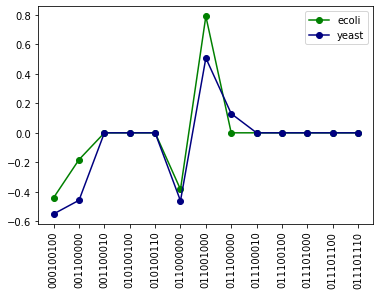

In [61]:
plt.xticks(rotation=90)
plt.plot(ecoli['adjmatrix'], ecoli['z_n'], 'go-', label = 'ecoli')
plt.plot(yeast['adjmatrix'], yeast['z_n'], 'navy', linestyle = '-', marker = 'o', label = 'yeast')
plt.legend(loc='upper right')


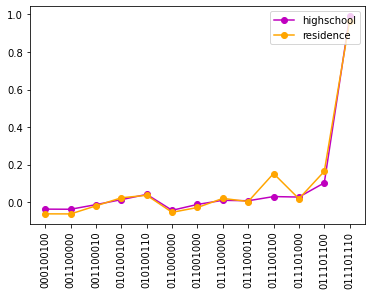

In [54]:
plt.xticks(rotation=90)

plt.plot(highschool['adjmatrix'], highschool['z_n'], 'mo-', label = 'highschool')
plt.plot(residence['adjmatrix'], residence['z_n'], 'orange', linestyle = '-', marker = 'o', label = 'residence')
plt.legend(loc='upper right')

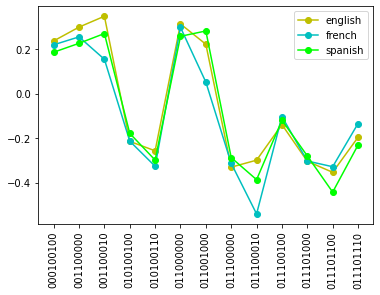

In [57]:
plt.xticks(rotation=90)
plt.plot(english['adjmatrix'], english['z_n'], 'yo-', label = 'english')
plt.plot(french['adjmatrix'], french['z_n'], 'co-', label = 'french')
plt.plot(spanish['adjmatrix'], spanish['z_n'], 'lime', linestyle = '-', marker = 'o', label = 'spanish')
plt.legend(loc='upper right')

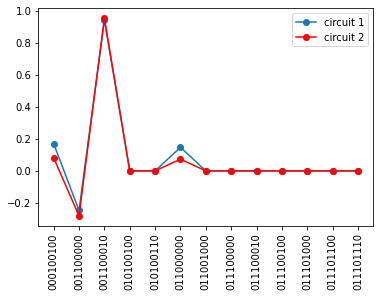

In [38]:
plt.xticks(rotation=90)
plt.plot(circuit1['adjmatrix'], circuit1['z_n'], 'o-', label = 'circuit 1')
plt.plot(circuit2['adjmatrix'], circuit2['z_n'], 'ro-', label = 'circuit 2')
plt.legend(loc='upper right')

Below follows the correlation matrix of the z_scores:

<AxesSubplot:>

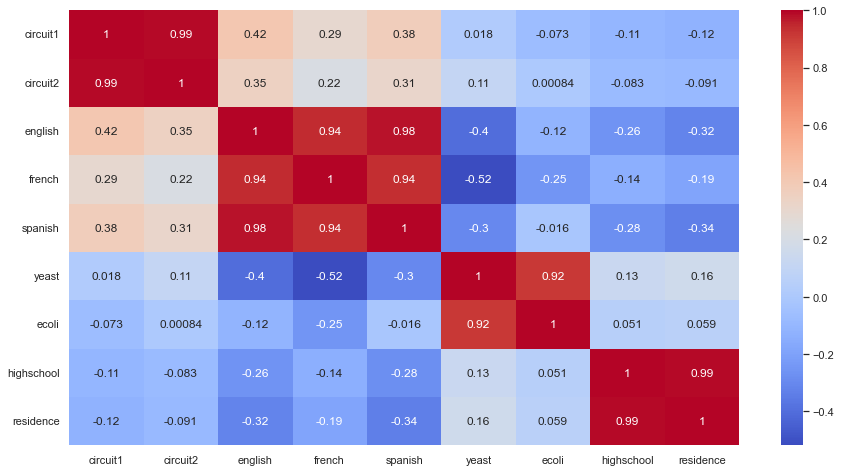

In [139]:
#https://www.delftstack.com/howto/seaborn/size-of-seaborn-heatmap/

data = list(zip(circuit1.z_n,
                circuit2.z_n,
                english.z_n,
                french.z_n,
                spanish.z_n,
                yeast.z_n,
                ecoli.z_n,
                highschool.z_n,
                residence.z_n))

z_mat = pd.DataFrame(data,
                     columns=['circuit1', 'circuit2', 'english', 'french', 'spanish', 'yeast', 'ecoli', 'highschool', 'residence'])


cm = sns.color_palette("coolwarm", as_cmap=True)
sns.set(rc = {'figure.figsize':(15,8)})

sns.heatmap(z_mat.corr(), annot = True, cmap = cm)

 ## e) Your task is to find the ”family” of the three ”unknown” networks given in unknown.zip. You should justify your answer by computing and plotting their motif significance profiles and by adding them to the previous heatmap. Each network will clearly belong to one of the groups discovered on the previous question.

Repeating the procedure of the previous question, we can determine the significance profile for each unknown network. We present the corresponding plot below.

In [71]:
unknown_1 = pd.read_csv('raw_nw1.txt', dtype = types)
unknown_1 = unknown_1.assign(z_n = z_norm(unknown_1))

unknown_2 = pd.read_csv('raw_nw2.txt', dtype = types)
unknown_2 = unknown_2.assign(z_n = z_norm(unknown_2))

unknown_3 = pd.read_csv('raw_nw3.txt', dtype = types)
unknown_3 = unknown_3.assign(z_n = z_norm(unknown_3))

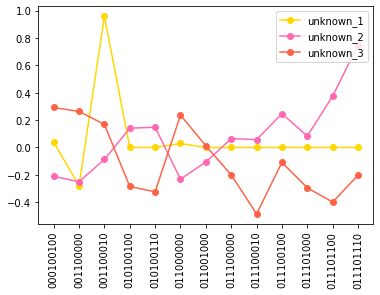

In [75]:
plt.xticks(rotation=90)
plt.plot(unknown_1['adjmatrix'], unknown_1['z_n'], 'gold', linestyle = '-', marker = 'o', label = 'unknown_1')
plt.plot(unknown_2['adjmatrix'], unknown_2['z_n'], 'hotpink', linestyle = '-', marker = 'o', label = 'unknown_2')
plt.plot(unknown_3['adjmatrix'], unknown_3['z_n'], 'tomato', linestyle = '-', marker = 'o', label = 'unknown_3')
plt.legend(loc='upper right')

It is easy to assign all these networks to one of the previously assigned groups. Unknown network #1 displays a significance profile that is very similar to the circuit networks we examined previously.

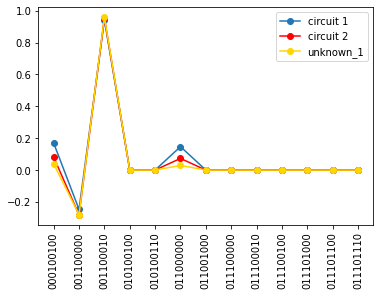

In [74]:
plt.xticks(rotation=90)
plt.plot(circuit1['adjmatrix'], circuit1['z_n'], 'o-', label = 'circuit 1')
plt.plot(circuit2['adjmatrix'], circuit2['z_n'], 'ro-', label = 'circuit 2')
plt.plot(unknown_1['adjmatrix'], unknown_1['z_n'], 'gold', linestyle = '-', marker = 'o', label = 'unknown_1')
plt.legend(loc='upper right')

Network #2 fits closely to the significance profiles found in the highschool and residence networks, though with more variance on its normalized Z scores:

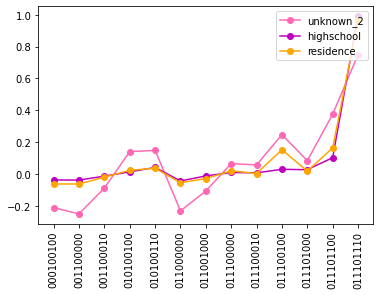

In [79]:
plt.xticks(rotation=90)
plt.plot(unknown_2['adjmatrix'], unknown_2['z_n'], 'hotpink', linestyle = '-', marker = 'o', label = 'unknown_2')
plt.plot(highschool['adjmatrix'], highschool['z_n'], 'mo-', label = 'highschool')
plt.plot(residence['adjmatrix'], residence['z_n'], 'orange', linestyle = '-', marker = 'o', label = 'residence')
plt.legend(loc='upper right')

As for network 3, it fit smoothly with the language networks group.

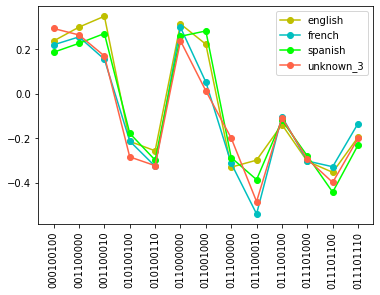

In [76]:
plt.xticks(rotation=90)
plt.plot(english['adjmatrix'], english['z_n'], 'yo-', label = 'english')
plt.plot(french['adjmatrix'], french['z_n'], 'co-', label = 'french')
plt.plot(spanish['adjmatrix'], spanish['z_n'], 'lime', linestyle = '-', marker = 'o', label = 'spanish')
plt.plot(unknown_3['adjmatrix'], unknown_3['z_n'], 'tomato', linestyle = '-', marker = 'o', label = 'unknown_3')
plt.legend(loc='upper right')

Below we present the updated heatmap that includes the unknown networks.

<AxesSubplot:>

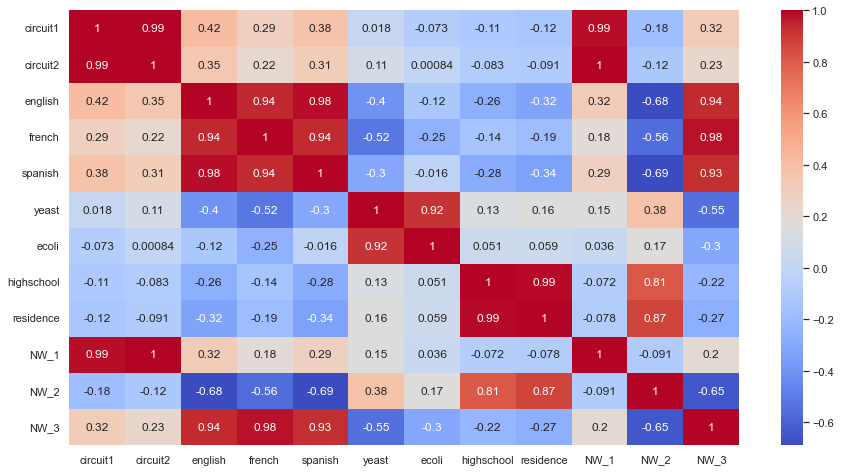

In [140]:
z_mat_corr = z_mat.assign(NW_1 =unknown_1.z_n, NW_2 = unknown_2.z_n, NW_3 = unknown_3.z_n).corr()

sns.heatmap(z_mat_corr, annot = True, cmap = cm)